In [ ]:
API_URL = "https://api.helmholtz-blablador.fz-juelich.de/v1/"
API_KEY = ""
API_MODEL = "alias-llama3-huge"

from openai import OpenAI

client = OpenAI(
    api_key=API_KEY,
    base_url=API_URL
)

In [15]:
import pandas as pd

df_results_all = pd.DataFrame()

In [17]:

positions = [0, 4, 9, 14, 19]  
rel3_count = 1           
rel0_count = 19
sample_count = rel0_count + 1 
max_qids = 40            

In [22]:

import pandas as pd

from slt_positional_bias.dataset import generate_merged_data_frame, sort_data_frame, store_df_as_parquet, load_parquet_as_df

# Liste für Ergebnisse
results = []
df_final = load_parquet_as_df("output_cleaned_df")

topic_ids = df_final['topic_id'].unique()[:max_qids]

for topic_id in topic_ids:
    df_topic = df_final[df_final['topic_id'] == topic_id]

    # Relevante und irrelevante Dokumente holen
    rel_3_docs = df_topic[df_topic['rel_scoring'] == 3].head(rel3_count)
    rel_0_docs = df_topic[df_topic['rel_scoring'] == 0].head(rel0_count)

    query = rel_3_docs['topic'].iloc[0]
    rel_3_text = ' '.join(rel_3_docs['doc'].tolist())
    rel_0_texts = rel_0_docs['doc'].tolist()

    for pos in positions:
        # Kontext aufbauen
        text_list = rel_0_texts.copy()
        if pos >= len(text_list):
            text_list.append(rel_3_text)
        else:
            text_list.insert(pos, rel_3_text)

        context_string = ' '.join(text_list)

        # Prompt erstellen
        user_prompt = f"""
        Context:
        {context_string}

        Question:
        {query}

        Answer:"""
        system_prompt = "You are a helpful assistant answering a question based on retrieved context information."

        # Modell antworten lassen
        response = client.chat.completions.create(
            model=API_MODEL,
            temperature=0.4,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
        )
        answer = response.choices[0].message.content.strip()
 
        evaluation_prompt = f"""
        You are evaluating a language model's answer based on a context of {sample_count} sections: one highly relevant, and {rel0_count} irrelevant.

        Only the following section is relevant:
        \"\"\"{rel_3_text}\"\"\"

        This is Answer from the model based on {sample_count} sections:
        \"\"\"{answer}\"\"\"

        Question:
        Is the answer mainly based on the relevant section?

        Reply with exactly one word: Yes or No
        """
        eval_response = client.chat.completions.create(
            model=API_MODEL,
            temperature=0,
            messages=[
                {"role": "user", "content": evaluation_prompt}
                ],
        )
        eval_result = eval_response.choices[0].message.content.strip()

        # Speichern
        results.append({
            'topic_id': topic_id,
            'position': pos,
            'eval_result': eval_result
        })

# DataFrame erstellen
df_results = pd.DataFrame(results)

# An globalen Speicher anhängen (wenn vorhanden)
try:
    df_results_all = pd.concat([df_results_all, df_results], ignore_index=True)
except NameError:
    df_results_all = df_results.copy()

# Ergebnisse anzeigen
print("\nEval-Ergebnisse (Stichprobe):")
print(df_results_all['eval_result'].value_counts())


InternalServerError: <!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">
<html><head>
<title>502 Proxy Error</title>
</head><body>
<h1>Proxy Error</h1>
<p>The proxy server received an invalid
response from an upstream server.<br />
The proxy server could not handle the request<p>Reason: <strong>Error reading from remote server</strong></p></p>
</body></html>

In [21]:
store_df_as_parquet(df_results_all, "results14")

In [28]:
df_results_all = load_parquet_as_df("results12")

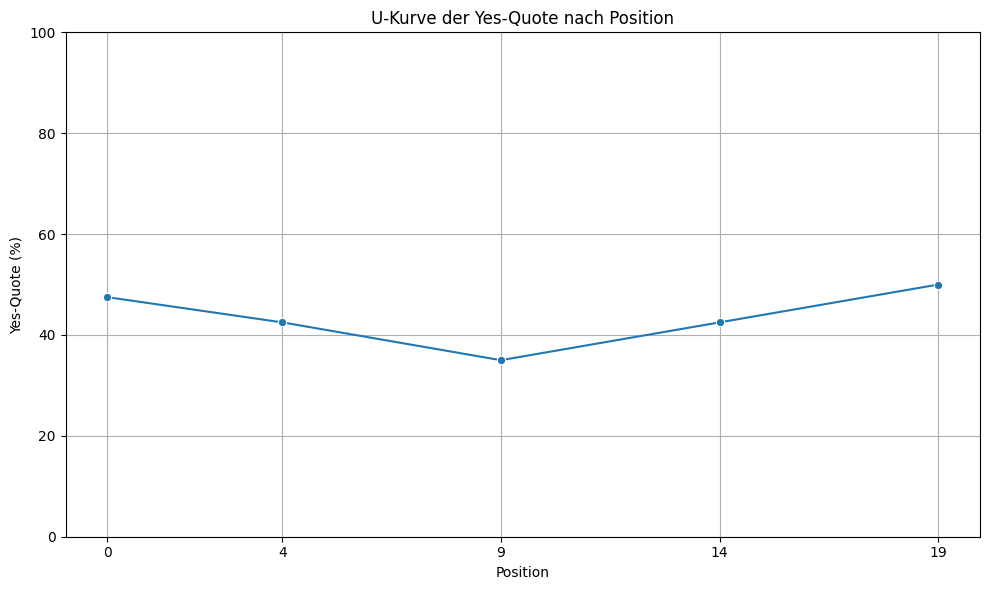

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_results_all['is_yes'] = df_results_all['eval_result'].apply(
    lambda x: x.split("</think>")[-1].strip().lower().startswith("yes")
).astype(int)

u_curve_df = df_results_all.groupby('position')['is_yes'].agg(['mean', 'count'])
u_curve_df.rename(columns={'mean': 'yes_rate', 'count': 'num_samples'}, inplace=True)
u_curve_df = u_curve_df.reset_index()
u_curve_df['yes_rate_pct'] = u_curve_df['yes_rate'] * 100

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=u_curve_df,
    x='position',
    y='yes_rate_pct',
    marker='o'
)

positions = u_curve_df['position'].unique()
plt.xticks(positions) 

plt.title('U-Kurve der Yes-Quote nach Position')
plt.xlabel('Position')
plt.ylabel('Yes-Quote (%)')
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()